In [34]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import math
import time
import os
import sys
import json
import pickle

import scipy as sp
from scipy import signal

from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

from tensorflow import keras

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Conv2D, MaxPool2D, Dropout,Flatten, Conv1D, MaxPool1D
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn import metrics

#from statsmodels.tsa.seasonal import seasonal_decompose
#from statsmodels.graphics.tsaplots import plot_acf

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import os, warnings, random
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import keras.layers as L

from keras import Model
from keras.layers import Layer
from tensorflow.python.keras import backend as K
#from keras.backend import backend as K
#import keras.backend as K
from keras.layers import Input, Dense, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.metrics import mean_squared_error

from tensorflow.python.keras import optimizers as optimizers


In [35]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_virtual_device_configuration(gpu,[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

Num GPUs Available:  1


In [36]:
def encode_phase(df, name):
    phase = df[name].values.tolist()
    x = np.zeros((len(df[name]),1))
    y = np.zeros((len(df[name]),1))
    for i in range (len(phase)): 
        phi = math.radians(phase[i])
        x[i] = math.cos(phi)
        y[i] = math.sin(phi)

    name_x = name[0] + '_ph_hip_x'
    name_y = name[0] + '_ph_hip_y'

    df[name_x] = x
    df[name_y] = y

In [37]:
def encode_gait_percentage(df, name):
    percent = df[name].values.tolist()
    X = np.zeros((len(df[name]),1))
    Y = np.zeros((len(df[name]),1))
    for i in range (len(percent)):
        phi = percent[i] * 2 * math.pi / 100
        X[i] = math.cos(phi)
        Y[i] = math.sin(phi)
    df['X'] = X
    df['Y'] = Y
  
def convert_data(d_x, d_y, look_back = 10, fore_cast = 5):
    dataX = []
    dataY = []

    for i in range(look_back, len(d_x) - fore_cast):
        dataX.append(d_x[i - look_back: i])
        dataY.append(d_y[i + fore_cast,:])

    return np.array(dataX), np.array(dataY)

def get_train_data_from_df(all_data, test_ratio):
    all_data.info()
    cycle = 0
    cycle_list = []

    start = 0

    for i in range(len(all_data) - 1):
        if (all_data['perc'][i+1] == 0):
            cycle += 1
            cycle_list.append(all_data.iloc[start:i])
            start = i+1

    random.shuffle(cycle_list)
    source_table = pd.concat(cycle_list, axis=0, ignore_index=True)

    # For hip: source_table = source_table.drop(["lgrf", "rgrf", "lcop","rcop"], axis = 1)

    # all features:  "lcop", "rcop", "lgrf", "rgrf", "l_ph_hip", "r_ph_hip", "st_sw_phase_l", "st_sw_phase_r", "st_l_l", "st_l_r", "leg_len", "weight"

    drop_list = ["lgrf", "rgrf","lcop", "rcop", "l_ph_hip", "r_ph_hip", "st_sw_phase_l", "st_l_l", "st_l_r"]
    source_table = source_table.drop(["lgrf", "rgrf", "st_sw_phase_l", "st_sw_phase_r", "leg_len", "weight", "rcop","r_ph_hip","st_l_r"], axis = 1)
    source_table
    x = source_table
    x = x.drop(['perc'], axis=1)
    # scaler = MinMaxScaler()
    # x_scaled = scaler.fit_transform(x)
    # x_scaled = pd.DataFrame(x_scaled)

    encode_gait_percentage(source_table, 'perc')
    y = source_table[["X","Y"]]
    # data_x = x_scaled
    data_x=x.values
    x.info()
    data_y = y.values.reshape(-1,2)

    X_train, X_test,y_train, y_test = train_test_split(data_x, data_y ,
                            test_size=0.25,
                            shuffle=False)
    look_back = 10
    fore_cast = 1

    train_x, train_y = convert_data(X_train, y_train, look_back, fore_cast)
    validation_x, validation_y = convert_data(X_test, y_test, look_back, fore_cast)

    return train_x, train_y, validation_x, validation_y


import random
def get_data_frames_from_files(path, file_names, subject_dict, subjects):
    file_list=[]
    for i in range (len(file_names)):

        subject = file_names[i].split('_')[0]
        if not subject in subjects:
            continue
        else:
            print(file_names[i])
        leg_len = subject_dict[subject][0]
        weight = subject_dict[subject][1]
        tmp=pd.read_excel(path+ file_names[i], sheet_name='Sheet1')
        perc_column = tmp['perc']
        tmp = tmp.drop(columns=['perc'])
        scaler = MinMaxScaler()

    # Normalize each column separately
        normalized_data = scaler.fit_transform(tmp)
        column_names = tmp.columns

        normalized_df = pd.DataFrame(normalized_data, columns=column_names)
        tmp['l_ph_hip']=tmp['l_ph_hip']/300
        tmp['r_ph_hip']=tmp['r_ph_hip']/300
        tmp['l_ph_fo']=tmp['l_ph_fo']/300
        tmp['r_ph_fo']=tmp['r_ph_fo']/300
        tmp['lcop']= tmp['lcop']*1000
        tmp['rcop']=tmp['rcop']*1000
        tmp['strike_frame']=tmp['strike_frame']/400
        tmp['st_sw_phase']=tmp['st_sw_phase']/200
        normalized_df =tmp
        normalized_df['leg_len']=leg_len
        normalized_df['weight']=weight
        normalized_df['perc']= perc_column
        # normalized_df.insert(tmp.columns.get_loc('col1'), 'perc', perc_column)

        file_list.append(normalized_df)

    random.shuffle(file_list)

    all_data = pd.concat(file_list, axis=0, ignore_index=True)
    return all_data


seq_len=10
n_features=11
#train_x=np.zeros((10,10,11))
#encoder_model().summary()
#decoder_model().summary()

def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        curLR = optimizer.lr
        return curLR
    return lr

def custom_loss(y_true, y_pred):
    #angle_true = ((math.atan2(y_true[:,1],y_true[:,0]) + 2*math.pi) % (2*math.pi))
    #angle_pred = ((math.atan2(y_pred[:,1],y_pred[:,0]) + 2*math.pi) % (2*math.pi)) 

    angle_true = ((K.math_ops.atan2(y_true[:,1],y_true[:,0]) + 2*math.pi) % (2*math.pi))
    angle_pred = ((K.math_ops.atan2(y_pred[:,1],y_pred[:,0]) + 2*math.pi) % (2*math.pi)) 

    #angle_true = tf.make_ndarray(y_true)
    #angle_pred = tf.make_ndarray(y_pred)
    
    #print("y_true: ", y_true.size())
    #print("info: ", y_true.info())
    #print("y_pred: ", y_pred.shape())
    #print("y_true:", y_true.shape)
    #a = K.argmax(y_true, axis=1)
    print("ang_pred: ",angle_pred)
    #print(angle_pred.shape)
    loss = tf.keras.losses.mean_squared_error(angle_true, angle_pred)
    return loss

def train_mlp_model(train_x, train_y, look_back):
    epochs = 30
    batch_size = 32                                                                
    learning_rate = 1e-2

    # learning rate scheduler
    use_lr_scheduler = True
    lr_factor = 0.5
    lr_patience = 8
    lr_threshold = 0.01
    lr_min_rate = 1e-6

    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.1)
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

    mlp_model = Sequential()
    mlp_model.add(Conv1D(100, kernel_size=3, strides=1,input_shape=(look_back, train_x.shape[2]), activation='relu'))
    mlp_model.add(MaxPool1D(pool_size=3, strides=1))
    mlp_model.add(Dropout(0.1))
    mlp_model.add(Conv1D(32, kernel_size = 2, strides = 1, activation='tanh'))
    mlp_model.add(MaxPool1D(pool_size=2, strides=1))
    mlp_model.add(Dropout(0.1))
    #mlp_model.add(Conv1D(8, kernel_size = 2, strides = 1, activation = 'tanh'))
    #mlp_model.add(MaxPool1D(pool_size=2, strides=1))
    #mlp_model.add(Dropout(0.2))
    mlp_model.add(Flatten())
    mlp_model.add(Dense(2))

    print(mlp_model.summary())

    monitor = EarlyStopping(monitor='loss', min_delta=1e-5, patience=2, verbose=1, mode='auto')

    #optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    mlp_model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy','mae','mse'])
    history = mlp_model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, callbacks=monitor,verbose=1)
   
    return mlp_model

def test_model_get_results(mlp_model, validation_x, validation_y, display_flag, tag, file):
    print("validation_x shape",validation_x.shape)
    testPredict = mlp_model.predict(validation_x)
    print(validation_y.shape)
    print(testPredict.shape)
    testScore = np.sqrt(mean_squared_error(validation_y, testPredict))
    # print(testScore)
    # print('Test Score: %.2f RMSE' % (testScore))
    pred = np.zeros((len(testPredict),1))
    ang_pred = np.zeros((len(testPredict),1))

    for iter in range(len(testPredict)):
        x = testPredict[iter][0]
        y = testPredict[iter][1]
        pred[iter] = ((math.atan2(y,x) + 2*math.pi) % (2*math.pi)) * (100 / (2*math.pi))
        ang_pred[iter] = ((math.atan2(y,x) + 2*math.pi) % (2*math.pi))

    actual = np.zeros((len(validation_y),1))
    ang_act = np.zeros((len(validation_y),1))

    for iter in range(len(validation_y)):
        x =validation_y[iter][0]
        y =validation_y[iter][1]
        # st_frame = validation_x[0,9,7]

        actual[iter] = ((math.atan2(y,x) + 2*math.pi) % (2*math.pi)) * (100 / (2*math.pi))
        ang_act[iter] = ((math.atan2(y,x) + 2*math.pi) % (2*math.pi))
        # if st_frame>100 and pred[iter]<15:
        #     pred[iter]=100-pred[iter]
        # if st_frame<90 and pred[iter]>85:
        #     pred[iter]=100-pred[iter]


    cor_actual=[]
    cor_pred=[]
    prec_list=[]

    for i in range(5):
        correct = 0
        for iter in range(len(actual)):
            # if (actual[iter]>98) or(actual[iter]<3):
            #     correct+=1
            #     continue
            if (abs(actual[iter] - pred[iter]) <= (i+1)):
                correct+=1
            cor_pred.append(pred[iter])
            cor_actual.append(actual[iter])
        prec=correct * 100/len(actual)
        print("Precision ", i+1, ": ", prec)
        # file.write(str(prec))
        # file.write("\n")
        prec_list.append(prec)

    rmse = 0
    length = len(actual)
    for i in range(len(actual)):
        if abs (pred[i] - actual[i]) >=90:
            length -= 1
        else:
            rmse = rmse + pow(pred[i] - actual[i], 2)
    rmse = rmse / length
    rmse = math.sqrt(rmse)

    if os.path.exists(result_pkl_file):
        with open(result_pkl_file,'rb') as pkl_file:
            res_dict=pickle.load(pkl_file)
    else:
        res_dict={}
    result={}
    result['rmse']=rmse
    result['prec_list']=prec_list
    res_dict[tag]=result
    with open(result_pkl_file, 'wb')as pkl_file:
        pickle.dump(res_dict, pkl_file)


    print(rmse)
    # file.write("rmse "+str(rmse))
    # file.write("\n")
    if display_flag:
        plt.scatter(cor_actual, cor_pred, facecolors='none', edgecolors='crimson',alpha=0.4)
        p1 = max(max(cor_pred), max(cor_actual))
        p2 = min(min(cor_pred), min(cor_actual))

        ci = 0.1 * np.std([p1,p2]) / np.mean([p1,p2])

        plt.plot([p1, p2], [p1, p2], 'b-', linewidth =3)
        plt.title('Actual vs Prediction')
        plt.savefig(result_path+tag+"__res.png")

    return prec_list, rmse


Subject combination : ['AK', 'SD', 'PH', 'YC', 'JL', 'JS', 'PK', 'SOE', 'TH', 'SKS', 'VN']
All Data Info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 572285 entries, 0 to 572284
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   lcop           572285 non-null  float64
 1   rcop           572285 non-null  float64
 2   lgrf           572285 non-null  float64
 3   rgrf           572285 non-null  float64
 4   l_ph_hip       572285 non-null  float64
 5   r_ph_hip       572285 non-null  float64
 6   st_sw_phase_l  572285 non-null  float64
 7   st_sw_phase_r  572285 non-null  float64
 8   st_l_l         572285 non-null  float64
 9   st_l_r         572285 non-null  float64
 10  leg_len        572285 non-null  float64
 11  weight         572285 non-null  float64
 12  perc           572285 non-null  float64
dtypes: float64(13)
memory usage: 56.8 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 572285 entries,

/home/hikikomori/miniconda3/envs/clean_gait_phase/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ conv1d_72 (Conv1D)              │ (None, 8, 100)            │      1,000 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling1d_72 (MaxPooling1D) │ (None, 6, 100)            │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_72 (Dropout)            │ (None, 6, 100)            │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv1d_73 (Conv1D)              │ (None, 5, 32)             │      6,432 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling1d_73 (MaxPooling1D) │ (None, 4, 32)             │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_73 (Dropout)            │ (None, 4, 32)             │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten_36 (Flatten)            │ (None, 128)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_36 (Dense)                │ (None, 2)                 │        258 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 7,690 (30.04 KB)

 Trainable params: 7,690 (30.04 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/30
13346/13346 ━━━━━━━━━━━━━━━━━━━━ 75s 5ms/step - accuracy: 0.9586 - loss: 0.0287 - mae: 0.1216 - mse: 0.0287
Epoch 2/30
13346/13346 ━━━━━━━━━━━━━━━━━━━━ 72s 5ms/step - accuracy: 0.9662 - loss: 0.0158 - mae: 0.0942 - mse: 0.0158
Epoch 3/30
13346/13346 ━━━━━━━━━━━━━━━━━━━━ 72s 5ms/step - accuracy: 0.9662 - loss: 0.0157 - mae: 0.0937 - mse: 0.0157
Epoch 4/30
13346/13346 ━━━━━━━━━━━━━━━━━━━━ 72s 5ms/step - accuracy: 0.9664 - loss: 0.0157 - mae: 0.0937 - mse: 0.0157
Epoch 5/30
13346/13346 ━━━━━━━━━━━━━━━━━━━━ 73s 5ms/step - accuracy: 0.9667 - loss: 0.0158 - mae: 0.0938 - mse: 0.0158
Epoch 6/30
13346/13346 ━━━━━━━━━━━━━━━━━━━━ 73s 5ms/step - accuracy: 0.9663 - loss: 0.0158 - mae: 0.0939 - mse: 0.0158
Epoch 7/30
13346/13346 ━━━━━━━━━━━━━━━━━━━━ 87s 7ms/step - accuracy: 0.9667 - loss: 0.0157 - mae: 0.0937 - mse: 0.0157
Epoch 7: early stopping
validation_x shape (142351, 10, 3)
4449/4449 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
(142351, 2)
(142351, 2)
Precision  1 :  37.09071239401199
P

/tmp/ipykernel_364/3673594883.py:248: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rmse = math.sqrt(rmse)


2.6909062255250595
testing on : VP
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54773 entries, 0 to 54772
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   lcop           54773 non-null  float64
 1   rcop           54773 non-null  float64
 2   lgrf           54773 non-null  float64
 3   rgrf           54773 non-null  float64
 4   l_ph_hip       54773 non-null  float64
 5   r_ph_hip       54773 non-null  float64
 6   st_sw_phase_l  54773 non-null  float64
 7   st_sw_phase_r  54773 non-null  float64
 8   st_l_l         54773 non-null  float64
 9   st_l_r         54773 non-null  float64
 10  leg_len        54773 non-null  float64
 11  weight         54773 non-null  float64
 12  perc           54773 non-null  float64
dtypes: float64(13)
memory usage: 5.4 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54286 entries, 0 to 54285
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ---

/tmp/ipykernel_364/3673594883.py:248: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rmse = math.sqrt(rmse)


3.177005671444675
Subject combination : ['VP', 'SD', 'PH', 'YC', 'JL', 'JS', 'PK', 'SOE', 'TH', 'SKS', 'VN']
All Data Info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569770 entries, 0 to 569769
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   lcop           569770 non-null  float64
 1   rcop           569770 non-null  float64
 2   lgrf           569770 non-null  float64
 3   rgrf           569770 non-null  float64
 4   l_ph_hip       569770 non-null  float64
 5   r_ph_hip       569770 non-null  float64
 6   st_sw_phase_l  569770 non-null  float64
 7   st_sw_phase_r  569770 non-null  float64
 8   st_l_l         569770 non-null  float64
 9   st_l_r         569770 non-null  float64
 10  leg_len        569770 non-null  float64
 11  weight         569770 non-null  float64
 12  perc           569770 non-null  float64
dtypes: float64(13)
memory usage: 56.5 MB
<class 'pandas.core.frame.DataFrame'>
RangeInde

/home/hikikomori/miniconda3/envs/clean_gait_phase/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ conv1d_74 (Conv1D)              │ (None, 8, 100)            │      1,000 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling1d_74 (MaxPooling1D) │ (None, 6, 100)            │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_74 (Dropout)            │ (None, 6, 100)            │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv1d_75 (Conv1D)              │ (None, 5, 32)             │      6,432 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling1d_75 (MaxPooling1D) │ (None, 4, 32)             │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_75 (Dropout)            │ (None, 4, 32)             │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten_37 (Flatten)            │ (None, 128)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_37 (Dense)                │ (None, 2)                 │        258 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 7,690 (30.04 KB)

 Trainable params: 7,690 (30.04 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/30
13288/13288 ━━━━━━━━━━━━━━━━━━━━ 80s 6ms/step - accuracy: 0.9564 - loss: 0.0300 - mae: 0.1234 - mse: 0.0300
Epoch 2/30
13288/13288 ━━━━━━━━━━━━━━━━━━━━ 69s 5ms/step - accuracy: 0.9654 - loss: 0.0164 - mae: 0.0956 - mse: 0.0164
Epoch 3/30
13288/13288 ━━━━━━━━━━━━━━━━━━━━ 73s 5ms/step - accuracy: 0.9654 - loss: 0.0162 - mae: 0.0951 - mse: 0.0162
Epoch 4/30
13288/13288 ━━━━━━━━━━━━━━━━━━━━ 83s 6ms/step - accuracy: 0.9654 - loss: 0.0163 - mae: 0.0952 - mse: 0.0163
Epoch 5/30
13288/13288 ━━━━━━━━━━━━━━━━━━━━ 72s 5ms/step - accuracy: 0.9651 - loss: 0.0162 - mae: 0.0950 - mse: 0.0162
Epoch 5: early stopping
validation_x shape (141729, 10, 3)
4430/4430 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
(141729, 2)
(141729, 2)
Precision  1 :  35.49591121083194
Precision  2 :  62.51367045558778
Precision  3 :  79.91025125415405
Precision  4 :  89.038940513233
Precision  5 :  93.89680305371519


/tmp/ipykernel_364/3673594883.py:248: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rmse = math.sqrt(rmse)


2.4561924638441357
testing on : AK
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57288 entries, 0 to 57287
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   lcop           57288 non-null  float64
 1   rcop           57288 non-null  float64
 2   lgrf           57288 non-null  float64
 3   rgrf           57288 non-null  float64
 4   l_ph_hip       57288 non-null  float64
 5   r_ph_hip       57288 non-null  float64
 6   st_sw_phase_l  57288 non-null  float64
 7   st_sw_phase_r  57288 non-null  float64
 8   st_l_l         57288 non-null  float64
 9   st_l_r         57288 non-null  float64
 10  leg_len        57288 non-null  float64
 11  weight         57288 non-null  float64
 12  perc           57288 non-null  float64
dtypes: float64(13)
memory usage: 5.7 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56821 entries, 0 to 56820
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ---

/tmp/ipykernel_364/3673594883.py:248: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rmse = math.sqrt(rmse)


2.4921120307853797
Subject combination : ['VP', 'AK', 'PH', 'YC', 'JL', 'JS', 'PK', 'SOE', 'TH', 'SKS', 'VN']
All Data Info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 579277 entries, 0 to 579276
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   lcop           579277 non-null  float64
 1   rcop           579277 non-null  float64
 2   lgrf           579277 non-null  float64
 3   rgrf           579277 non-null  float64
 4   l_ph_hip       579277 non-null  float64
 5   r_ph_hip       579277 non-null  float64
 6   st_sw_phase_l  579277 non-null  float64
 7   st_sw_phase_r  579277 non-null  float64
 8   st_l_l         579277 non-null  float64
 9   st_l_r         579277 non-null  float64
 10  leg_len        579277 non-null  float64
 11  weight         579277 non-null  float64
 12  perc           579277 non-null  float64
dtypes: float64(13)
memory usage: 57.5 MB
<class 'pandas.core.frame.DataFrame'>
RangeInd

/home/hikikomori/miniconda3/envs/clean_gait_phase/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ conv1d_76 (Conv1D)              │ (None, 8, 100)            │      1,000 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling1d_76 (MaxPooling1D) │ (None, 6, 100)            │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_76 (Dropout)            │ (None, 6, 100)            │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv1d_77 (Conv1D)              │ (None, 5, 32)             │      6,432 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling1d_77 (MaxPooling1D) │ (None, 4, 32)             │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_77 (Dropout)            │ (None, 4, 32)             │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten_38 (Flatten)            │ (None, 128)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_38 (Dense)                │ (None, 2)                 │        258 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 7,690 (30.04 KB)

 Trainable params: 7,690 (30.04 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/30
13510/13510 ━━━━━━━━━━━━━━━━━━━━ 77s 6ms/step - accuracy: 0.9572 - loss: 0.0291 - mae: 0.1230 - mse: 0.0291
Epoch 2/30
13510/13510 ━━━━━━━━━━━━━━━━━━━━ 73s 5ms/step - accuracy: 0.9660 - loss: 0.0168 - mae: 0.0970 - mse: 0.0168
Epoch 3/30
13510/13510 ━━━━━━━━━━━━━━━━━━━━ 75s 6ms/step - accuracy: 0.9668 - loss: 0.0166 - mae: 0.0963 - mse: 0.0166
Epoch 4/30
13510/13510 ━━━━━━━━━━━━━━━━━━━━ 74s 5ms/step - accuracy: 0.9665 - loss: 0.0166 - mae: 0.0962 - mse: 0.0166
Epoch 5/30
13510/13510 ━━━━━━━━━━━━━━━━━━━━ 73s 5ms/step - accuracy: 0.9669 - loss: 0.0165 - mae: 0.0962 - mse: 0.0165
Epoch 6/30
13510/13510 ━━━━━━━━━━━━━━━━━━━━ 73s 5ms/step - accuracy: 0.9664 - loss: 0.0166 - mae: 0.0962 - mse: 0.0166
Epoch 6: early stopping
validation_x shape (144097, 10, 3)
4504/4504 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step
(144097, 2)
(144097, 2)
Precision  1 :  36.367863314295235
Precision  2 :  64.34415706086872
Precision  3 :  81.17656856145513
Precision  4 :  89.5875694844445
Precision  5 :  93.

/tmp/ipykernel_364/3673594883.py:248: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rmse = math.sqrt(rmse)


2.549523356257073
testing on : SD
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47781 entries, 0 to 47780
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   lcop           47781 non-null  float64
 1   rcop           47781 non-null  float64
 2   lgrf           47781 non-null  float64
 3   rgrf           47781 non-null  float64
 4   l_ph_hip       47781 non-null  float64
 5   r_ph_hip       47781 non-null  float64
 6   st_sw_phase_l  47781 non-null  float64
 7   st_sw_phase_r  47781 non-null  float64
 8   st_l_l         47781 non-null  float64
 9   st_l_r         47781 non-null  float64
 10  leg_len        47781 non-null  float64
 11  weight         47781 non-null  float64
 12  perc           47781 non-null  float64
dtypes: float64(13)
memory usage: 4.7 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47365 entries, 0 to 47364
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ----

/tmp/ipykernel_364/3673594883.py:248: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rmse = math.sqrt(rmse)


Subject combination : ['VP', 'AK', 'SD', 'YC', 'JL', 'JS', 'PK', 'SOE', 'TH', 'SKS', 'VN']
All Data Info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 567615 entries, 0 to 567614
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   lcop           567615 non-null  float64
 1   rcop           567615 non-null  float64
 2   lgrf           567615 non-null  float64
 3   rgrf           567615 non-null  float64
 4   l_ph_hip       567615 non-null  float64
 5   r_ph_hip       567615 non-null  float64
 6   st_sw_phase_l  567615 non-null  float64
 7   st_sw_phase_r  567615 non-null  float64
 8   st_l_l         567615 non-null  float64
 9   st_l_r         567615 non-null  float64
 10  leg_len        567615 non-null  float64
 11  weight         567615 non-null  float64
 12  perc           567615 non-null  float64
dtypes: float64(13)
memory usage: 56.3 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 567615 entries,

/home/hikikomori/miniconda3/envs/clean_gait_phase/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ conv1d_78 (Conv1D)              │ (None, 8, 100)            │      1,000 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling1d_78 (MaxPooling1D) │ (None, 6, 100)            │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_78 (Dropout)            │ (None, 6, 100)            │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv1d_79 (Conv1D)              │ (None, 5, 32)             │      6,432 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling1d_79 (MaxPooling1D) │ (None, 4, 32)             │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_79 (Dropout)            │ (None, 4, 32)             │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten_39 (Flatten)            │ (None, 128)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_39 (Dense)                │ (None, 2)                 │        258 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 7,690 (30.04 KB)

 Trainable params: 7,690 (30.04 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/30
13238/13238 ━━━━━━━━━━━━━━━━━━━━ 77s 6ms/step - accuracy: 0.9545 - loss: 0.0353 - mae: 0.1309 - mse: 0.0353
Epoch 2/30
13238/13238 ━━━━━━━━━━━━━━━━━━━━ 68s 5ms/step - accuracy: 0.9650 - loss: 0.0167 - mae: 0.0972 - mse: 0.0167
Epoch 3/30
13238/13238 ━━━━━━━━━━━━━━━━━━━━ 72s 5ms/step - accuracy: 0.9661 - loss: 0.0166 - mae: 0.0967 - mse: 0.0166
Epoch 4/30
13238/13238 ━━━━━━━━━━━━━━━━━━━━ 71s 5ms/step - accuracy: 0.9663 - loss: 0.0166 - mae: 0.0967 - mse: 0.0166
Epoch 5/30
13238/13238 ━━━━━━━━━━━━━━━━━━━━ 72s 5ms/step - accuracy: 0.9666 - loss: 0.0165 - mae: 0.0964 - mse: 0.0165
Epoch 6/30
13238/13238 ━━━━━━━━━━━━━━━━━━━━ 72s 5ms/step - accuracy: 0.9664 - loss: 0.0166 - mae: 0.0967 - mse: 0.0166
Epoch 6: early stopping
validation_x shape (141196, 10, 3)
4413/4413 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step
(141196, 2)
(141196, 2)
Precision  1 :  36.25527635343777
Precision  2 :  63.68523187625712
Precision  3 :  81.03628997988612
Precision  4 :  89.97492846822855
Precision  5 :  94.

/tmp/ipykernel_364/3673594883.py:248: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rmse = math.sqrt(rmse)


2.475859191438987
testing on : PH
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59443 entries, 0 to 59442
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   lcop           59443 non-null  float64
 1   rcop           59443 non-null  float64
 2   lgrf           59443 non-null  float64
 3   rgrf           59443 non-null  float64
 4   l_ph_hip       59443 non-null  float64
 5   r_ph_hip       59443 non-null  float64
 6   st_sw_phase_l  59443 non-null  float64
 7   st_sw_phase_r  59443 non-null  float64
 8   st_l_l         59443 non-null  float64
 9   st_l_r         59443 non-null  float64
 10  leg_len        59443 non-null  float64
 11  weight         59443 non-null  float64
 12  perc           59443 non-null  float64
dtypes: float64(13)
memory usage: 5.9 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58909 entries, 0 to 58908
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ----

/tmp/ipykernel_364/3673594883.py:248: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rmse = math.sqrt(rmse)


1.931391060280362
Subject combination : ['VP', 'AK', 'SD', 'PH', 'JL', 'JS', 'PK', 'SOE', 'TH', 'SKS', 'VN']
All Data Info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 577457 entries, 0 to 577456
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   lcop           577457 non-null  float64
 1   rcop           577457 non-null  float64
 2   lgrf           577457 non-null  float64
 3   rgrf           577457 non-null  float64
 4   l_ph_hip       577457 non-null  float64
 5   r_ph_hip       577457 non-null  float64
 6   st_sw_phase_l  577457 non-null  float64
 7   st_sw_phase_r  577457 non-null  float64
 8   st_l_l         577457 non-null  float64
 9   st_l_r         577457 non-null  float64
 10  leg_len        577457 non-null  float64
 11  weight         577457 non-null  float64
 12  perc           577457 non-null  float64
dtypes: float64(13)
memory usage: 57.3 MB
<class 'pandas.core.frame.DataFrame'>
RangeInde

/home/hikikomori/miniconda3/envs/clean_gait_phase/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ conv1d_80 (Conv1D)              │ (None, 8, 100)            │      1,000 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling1d_80 (MaxPooling1D) │ (None, 6, 100)            │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_80 (Dropout)            │ (None, 6, 100)            │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv1d_81 (Conv1D)              │ (None, 5, 32)             │      6,432 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling1d_81 (MaxPooling1D) │ (None, 4, 32)             │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_81 (Dropout)            │ (None, 4, 32)             │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten_40 (Flatten)            │ (None, 128)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_40 (Dense)                │ (None, 2)                 │        258 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 7,690 (30.04 KB)

 Trainable params: 7,690 (30.04 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/30
13469/13469 ━━━━━━━━━━━━━━━━━━━━ 81s 6ms/step - accuracy: 0.9573 - loss: 0.0283 - mae: 0.1208 - mse: 0.0283
Epoch 2/30
13469/13469 ━━━━━━━━━━━━━━━━━━━━ 73s 5ms/step - accuracy: 0.9657 - loss: 0.0156 - mae: 0.0940 - mse: 0.0156
Epoch 3/30
13469/13469 ━━━━━━━━━━━━━━━━━━━━ 75s 6ms/step - accuracy: 0.9657 - loss: 0.0155 - mae: 0.0937 - mse: 0.0155
Epoch 4/30
13469/13469 ━━━━━━━━━━━━━━━━━━━━ 75s 6ms/step - accuracy: 0.9662 - loss: 0.0155 - mae: 0.0935 - mse: 0.0155
Epoch 5/30
13469/13469 ━━━━━━━━━━━━━━━━━━━━ 75s 6ms/step - accuracy: 0.9659 - loss: 0.0154 - mae: 0.0933 - mse: 0.0154
Epoch 5: early stopping
validation_x shape (143655, 10, 3)
4490/4490 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
(143655, 2)
(143655, 2)
Precision  1 :  35.2901047648881
Precision  2 :  64.09383592635133
Precision  3 :  81.4277261494553
Precision  4 :  89.50332393581846
Precision  5 :  94.08304618704535


/tmp/ipykernel_364/3673594883.py:248: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rmse = math.sqrt(rmse)


2.5093445899367146
testing on : YC
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49601 entries, 0 to 49600
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   lcop           49601 non-null  float64
 1   rcop           49601 non-null  float64
 2   lgrf           49601 non-null  float64
 3   rgrf           49601 non-null  float64
 4   l_ph_hip       49601 non-null  float64
 5   r_ph_hip       49601 non-null  float64
 6   st_sw_phase_l  49601 non-null  float64
 7   st_sw_phase_r  49601 non-null  float64
 8   st_l_l         49601 non-null  float64
 9   st_l_r         49601 non-null  float64
 10  leg_len        49601 non-null  float64
 11  weight         49601 non-null  float64
 12  perc           49601 non-null  float64
dtypes: float64(13)
memory usage: 4.9 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49180 entries, 0 to 49179
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ---

/tmp/ipykernel_364/3673594883.py:248: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rmse = math.sqrt(rmse)


Subject combination : ['VP', 'AK', 'SD', 'PH', 'YC', 'JS', 'PK', 'SOE', 'TH', 'SKS', 'VN']
All Data Info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581777 entries, 0 to 581776
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   lcop           581777 non-null  float64
 1   rcop           581777 non-null  float64
 2   lgrf           581777 non-null  float64
 3   rgrf           581777 non-null  float64
 4   l_ph_hip       581777 non-null  float64
 5   r_ph_hip       581777 non-null  float64
 6   st_sw_phase_l  581777 non-null  float64
 7   st_sw_phase_r  581777 non-null  float64
 8   st_l_l         581777 non-null  float64
 9   st_l_r         581777 non-null  float64
 10  leg_len        581777 non-null  float64
 11  weight         581777 non-null  float64
 12  perc           581777 non-null  float64
dtypes: float64(13)
memory usage: 57.7 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581777 entries,

/home/hikikomori/miniconda3/envs/clean_gait_phase/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ conv1d_82 (Conv1D)              │ (None, 8, 100)            │      1,000 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling1d_82 (MaxPooling1D) │ (None, 6, 100)            │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_82 (Dropout)            │ (None, 6, 100)            │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv1d_83 (Conv1D)              │ (None, 5, 32)             │      6,432 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling1d_83 (MaxPooling1D) │ (None, 4, 32)             │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_83 (Dropout)            │ (None, 4, 32)             │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten_41 (Flatten)            │ (None, 128)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_41 (Dense)                │ (None, 2)                 │        258 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 7,690 (30.04 KB)

 Trainable params: 7,690 (30.04 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/30
13569/13569 ━━━━━━━━━━━━━━━━━━━━ 81s 6ms/step - accuracy: 0.9589 - loss: 0.0303 - mae: 0.1244 - mse: 0.0303
Epoch 2/30
13569/13569 ━━━━━━━━━━━━━━━━━━━━ 71s 5ms/step - accuracy: 0.9667 - loss: 0.0168 - mae: 0.0970 - mse: 0.0168
Epoch 3/30
13569/13569 ━━━━━━━━━━━━━━━━━━━━ 74s 5ms/step - accuracy: 0.9664 - loss: 0.0166 - mae: 0.0963 - mse: 0.0166
Epoch 4/30
13569/13569 ━━━━━━━━━━━━━━━━━━━━ 74s 5ms/step - accuracy: 0.9669 - loss: 0.0166 - mae: 0.0963 - mse: 0.0166
Epoch 5/30
13569/13569 ━━━━━━━━━━━━━━━━━━━━ 73s 5ms/step - accuracy: 0.9668 - loss: 0.0166 - mae: 0.0962 - mse: 0.0166
Epoch 6/30
13569/13569 ━━━━━━━━━━━━━━━━━━━━ 73s 5ms/step - accuracy: 0.9673 - loss: 0.0166 - mae: 0.0963 - mse: 0.0166
Epoch 7/30
13569/13569 ━━━━━━━━━━━━━━━━━━━━ 73s 5ms/step - accuracy: 0.9665 - loss: 0.0166 - mae: 0.0963 - mse: 0.0166
Epoch 7: early stopping
validation_x shape (144723, 10, 3)
4523/4523 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
(144723, 2)
(144723, 2)
Precision  1 :  36.3998811522702
Pre

/tmp/ipykernel_364/3673594883.py:248: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rmse = math.sqrt(rmse)


2.5065896026043335
testing on : JL
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45281 entries, 0 to 45280
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   lcop           45281 non-null  float64
 1   rcop           45281 non-null  float64
 2   lgrf           45281 non-null  float64
 3   rgrf           45281 non-null  float64
 4   l_ph_hip       45281 non-null  float64
 5   r_ph_hip       45281 non-null  float64
 6   st_sw_phase_l  45281 non-null  float64
 7   st_sw_phase_r  45281 non-null  float64
 8   st_l_l         45281 non-null  float64
 9   st_l_r         45281 non-null  float64
 10  leg_len        45281 non-null  float64
 11  weight         45281 non-null  float64
 12  perc           45281 non-null  float64
dtypes: float64(13)
memory usage: 4.5 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44834 entries, 0 to 44833
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ---

/tmp/ipykernel_364/3673594883.py:248: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rmse = math.sqrt(rmse)


Subject combination : ['VP', 'AK', 'SD', 'PH', 'YC', 'JL', 'PK', 'SOE', 'TH', 'SKS', 'VN']
All Data Info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 567546 entries, 0 to 567545
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   lcop           567546 non-null  float64
 1   rcop           567546 non-null  float64
 2   lgrf           567546 non-null  float64
 3   rgrf           567546 non-null  float64
 4   l_ph_hip       567546 non-null  float64
 5   r_ph_hip       567546 non-null  float64
 6   st_sw_phase_l  567546 non-null  float64
 7   st_sw_phase_r  567546 non-null  float64
 8   st_l_l         567546 non-null  float64
 9   st_l_r         567546 non-null  float64
 10  leg_len        567546 non-null  float64
 11  weight         567546 non-null  float64
 12  perc           567546 non-null  float64
dtypes: float64(13)
memory usage: 56.3 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 567546 entries,

/home/hikikomori/miniconda3/envs/clean_gait_phase/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_42"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ conv1d_84 (Conv1D)              │ (None, 8, 100)            │      1,000 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling1d_84 (MaxPooling1D) │ (None, 6, 100)            │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_84 (Dropout)            │ (None, 6, 100)            │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv1d_85 (Conv1D)              │ (None, 5, 32)             │      6,432 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling1d_85 (MaxPooling1D) │ (None, 4, 32)             │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_85 (Dropout)            │ (None, 4, 32)             │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten_42 (Flatten)            │ (None, 128)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_42 (Dense)                │ (None, 2)                 │        258 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 7,690 (30.04 KB)

 Trainable params: 7,690 (30.04 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/30
13238/13238 ━━━━━━━━━━━━━━━━━━━━ 79s 6ms/step - accuracy: 0.9576 - loss: 0.0300 - mae: 0.1230 - mse: 0.0300
Epoch 2/30
13238/13238 ━━━━━━━━━━━━━━━━━━━━ 70s 5ms/step - accuracy: 0.9680 - loss: 0.0161 - mae: 0.0945 - mse: 0.0161
Epoch 3/30
13238/13238 ━━━━━━━━━━━━━━━━━━━━ 73s 5ms/step - accuracy: 0.9680 - loss: 0.0157 - mae: 0.0936 - mse: 0.0157
Epoch 4/30
13238/13238 ━━━━━━━━━━━━━━━━━━━━ 72s 5ms/step - accuracy: 0.9679 - loss: 0.0158 - mae: 0.0938 - mse: 0.0158
Epoch 5/30
13238/13238 ━━━━━━━━━━━━━━━━━━━━ 73s 5ms/step - accuracy: 0.9674 - loss: 0.0159 - mae: 0.0938 - mse: 0.0159
Epoch 5: early stopping
validation_x shape (141193, 10, 3)
4413/4413 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
(141193, 2)
(141193, 2)
Precision  1 :  34.6341532512235
Precision  2 :  62.22121493275162
Precision  3 :  80.06062623501165
Precision  4 :  88.81318478961421
Precision  5 :  93.4274362043444


/tmp/ipykernel_364/3673594883.py:248: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rmse = math.sqrt(rmse)


2.6169678330547366
testing on : JS
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59512 entries, 0 to 59511
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   lcop           59512 non-null  float64
 1   rcop           59512 non-null  float64
 2   lgrf           59512 non-null  float64
 3   rgrf           59512 non-null  float64
 4   l_ph_hip       59512 non-null  float64
 5   r_ph_hip       59512 non-null  float64
 6   st_sw_phase_l  59512 non-null  float64
 7   st_sw_phase_r  59512 non-null  float64
 8   st_l_l         59512 non-null  float64
 9   st_l_r         59512 non-null  float64
 10  leg_len        59512 non-null  float64
 11  weight         59512 non-null  float64
 12  perc           59512 non-null  float64
dtypes: float64(13)
memory usage: 5.9 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58965 entries, 0 to 58964
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ---

/tmp/ipykernel_364/3673594883.py:248: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rmse = math.sqrt(rmse)


2.549310584144812
Subject combination : ['VP', 'AK', 'SD', 'PH', 'YC', 'JL', 'JS', 'SOE', 'TH', 'SKS', 'VN']
All Data Info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600143 entries, 0 to 600142
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   lcop           600143 non-null  float64
 1   rcop           600143 non-null  float64
 2   lgrf           600143 non-null  float64
 3   rgrf           600143 non-null  float64
 4   l_ph_hip       600143 non-null  float64
 5   r_ph_hip       600143 non-null  float64
 6   st_sw_phase_l  600143 non-null  float64
 7   st_sw_phase_r  600143 non-null  float64
 8   st_l_l         600143 non-null  float64
 9   st_l_r         600143 non-null  float64
 10  leg_len        600143 non-null  float64
 11  weight         600143 non-null  float64
 12  perc           600143 non-null  float64
dtypes: float64(13)
memory usage: 59.5 MB
<class 'pandas.core.frame.DataFrame'>
RangeInde

/home/hikikomori/miniconda3/envs/clean_gait_phase/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_43"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ conv1d_86 (Conv1D)              │ (None, 8, 100)            │      1,000 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling1d_86 (MaxPooling1D) │ (None, 6, 100)            │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_86 (Dropout)            │ (None, 6, 100)            │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv1d_87 (Conv1D)              │ (None, 5, 32)             │      6,432 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling1d_87 (MaxPooling1D) │ (None, 4, 32)             │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_87 (Dropout)            │ (None, 4, 32)             │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten_43 (Flatten)            │ (None, 128)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_43 (Dense)                │ (None, 2)                 │        258 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 7,690 (30.04 KB)

 Trainable params: 7,690 (30.04 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/30
13998/13998 ━━━━━━━━━━━━━━━━━━━━ 84s 6ms/step - accuracy: 0.9587 - loss: 0.0288 - mae: 0.1216 - mse: 0.0288
Epoch 2/30
13998/13998 ━━━━━━━━━━━━━━━━━━━━ 74s 5ms/step - accuracy: 0.9669 - loss: 0.0162 - mae: 0.0955 - mse: 0.0162
Epoch 3/30
13998/13998 ━━━━━━━━━━━━━━━━━━━━ 76s 5ms/step - accuracy: 0.9669 - loss: 0.0161 - mae: 0.0952 - mse: 0.0161
Epoch 4/30
13998/13998 ━━━━━━━━━━━━━━━━━━━━ 78s 6ms/step - accuracy: 0.9667 - loss: 0.0160 - mae: 0.0949 - mse: 0.0160
Epoch 5/30
13998/13998 ━━━━━━━━━━━━━━━━━━━━ 78s 6ms/step - accuracy: 0.9672 - loss: 0.0160 - mae: 0.0951 - mse: 0.0160
Epoch 5: early stopping
validation_x shape (149296, 10, 3)
4666/4666 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
(149296, 2)
(149296, 2)
Precision  1 :  36.96817061408209
Precision  2 :  64.5241667559747
Precision  3 :  81.51658450326867
Precision  4 :  90.27100525131283
Precision  5 :  94.33541421069553


/tmp/ipykernel_364/3673594883.py:248: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rmse = math.sqrt(rmse)


2.5401878291868556
testing on : PK
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26915 entries, 0 to 26914
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   lcop           26915 non-null  float64
 1   rcop           26915 non-null  float64
 2   lgrf           26915 non-null  float64
 3   rgrf           26915 non-null  float64
 4   l_ph_hip       26915 non-null  float64
 5   r_ph_hip       26915 non-null  float64
 6   st_sw_phase_l  26915 non-null  float64
 7   st_sw_phase_r  26915 non-null  float64
 8   st_l_l         26915 non-null  float64
 9   st_l_r         26915 non-null  float64
 10  leg_len        26915 non-null  float64
 11  weight         26915 non-null  float64
 12  perc           26915 non-null  float64
dtypes: float64(13)
memory usage: 2.7 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26544 entries, 0 to 26543
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ---

/tmp/ipykernel_364/3673594883.py:248: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rmse = math.sqrt(rmse)


Subject combination : ['VP', 'AK', 'SD', 'PH', 'YC', 'JL', 'JS', 'PK', 'TH', 'SKS', 'VN']
All Data Info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 574311 entries, 0 to 574310
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   lcop           574311 non-null  float64
 1   rcop           574311 non-null  float64
 2   lgrf           574311 non-null  float64
 3   rgrf           574311 non-null  float64
 4   l_ph_hip       574311 non-null  float64
 5   r_ph_hip       574311 non-null  float64
 6   st_sw_phase_l  574311 non-null  float64
 7   st_sw_phase_r  574311 non-null  float64
 8   st_l_l         574311 non-null  float64
 9   st_l_r         574311 non-null  float64
 10  leg_len        574311 non-null  float64
 11  weight         574311 non-null  float64
 12  perc           574311 non-null  float64
dtypes: float64(13)
memory usage: 57.0 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 574311 entries, 

/home/hikikomori/miniconda3/envs/clean_gait_phase/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_44"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ conv1d_88 (Conv1D)              │ (None, 8, 100)            │      1,000 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling1d_88 (MaxPooling1D) │ (None, 6, 100)            │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_88 (Dropout)            │ (None, 6, 100)            │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv1d_89 (Conv1D)              │ (None, 5, 32)             │      6,432 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling1d_89 (MaxPooling1D) │ (None, 4, 32)             │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_89 (Dropout)            │ (None, 4, 32)             │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten_44 (Flatten)            │ (None, 128)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_44 (Dense)                │ (None, 2)                 │        258 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 7,690 (30.04 KB)

 Trainable params: 7,690 (30.04 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/30
13396/13396 ━━━━━━━━━━━━━━━━━━━━ 80s 6ms/step - accuracy: 0.9555 - loss: 0.0316 - mae: 0.1245 - mse: 0.0316
Epoch 2/30
13396/13396 ━━━━━━━━━━━━━━━━━━━━ 73s 5ms/step - accuracy: 0.9682 - loss: 0.0160 - mae: 0.0947 - mse: 0.0160
Epoch 3/30
13396/13396 ━━━━━━━━━━━━━━━━━━━━ 75s 6ms/step - accuracy: 0.9686 - loss: 0.0159 - mae: 0.0941 - mse: 0.0159
Epoch 4/30
13396/13396 ━━━━━━━━━━━━━━━━━━━━ 76s 6ms/step - accuracy: 0.9681 - loss: 0.0159 - mae: 0.0941 - mse: 0.0159
Epoch 5/30
13396/13396 ━━━━━━━━━━━━━━━━━━━━ 75s 6ms/step - accuracy: 0.9681 - loss: 0.0159 - mae: 0.0943 - mse: 0.0159
Epoch 5: early stopping
validation_x shape (142882, 10, 3)
4466/4466 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
(142882, 2)
(142882, 2)
Precision  1 :  37.65624781288056
Precision  2 :  65.55269383127336
Precision  3 :  82.31127783765625
Precision  4 :  90.91628056718132
Precision  5 :  94.69282344871992


/tmp/ipykernel_364/3673594883.py:248: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rmse = math.sqrt(rmse)


2.434288227275646
testing on : SOE
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52747 entries, 0 to 52746
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   lcop           52747 non-null  float64
 1   rcop           52747 non-null  float64
 2   lgrf           52747 non-null  float64
 3   rgrf           52747 non-null  float64
 4   l_ph_hip       52747 non-null  float64
 5   r_ph_hip       52747 non-null  float64
 6   st_sw_phase_l  52747 non-null  float64
 7   st_sw_phase_r  52747 non-null  float64
 8   st_l_l         52747 non-null  float64
 9   st_l_r         52747 non-null  float64
 10  leg_len        52747 non-null  float64
 11  weight         52747 non-null  float64
 12  perc           52747 non-null  float64
dtypes: float64(13)
memory usage: 5.2 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52236 entries, 0 to 52235
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ---

/tmp/ipykernel_364/3673594883.py:248: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rmse = math.sqrt(rmse)


3.168795827971648
Subject combination : ['VP', 'AK', 'SD', 'PH', 'YC', 'JL', 'JS', 'PK', 'SOE', 'SKS', 'VN']
All Data Info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 567438 entries, 0 to 567437
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   lcop           567438 non-null  float64
 1   rcop           567438 non-null  float64
 2   lgrf           567438 non-null  float64
 3   rgrf           567438 non-null  float64
 4   l_ph_hip       567438 non-null  float64
 5   r_ph_hip       567438 non-null  float64
 6   st_sw_phase_l  567438 non-null  float64
 7   st_sw_phase_r  567438 non-null  float64
 8   st_l_l         567438 non-null  float64
 9   st_l_r         567438 non-null  float64
 10  leg_len        567438 non-null  float64
 11  weight         567438 non-null  float64
 12  perc           567438 non-null  float64
dtypes: float64(13)
memory usage: 56.3 MB
<class 'pandas.core.frame.DataFrame'>
RangeInde

/home/hikikomori/miniconda3/envs/clean_gait_phase/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_45"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ conv1d_90 (Conv1D)              │ (None, 8, 100)            │      1,000 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling1d_90 (MaxPooling1D) │ (None, 6, 100)            │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_90 (Dropout)            │ (None, 6, 100)            │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv1d_91 (Conv1D)              │ (None, 5, 32)             │      6,432 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling1d_91 (MaxPooling1D) │ (None, 4, 32)             │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_91 (Dropout)            │ (None, 4, 32)             │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten_45 (Flatten)            │ (None, 128)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_45 (Dense)                │ (None, 2)                 │        258 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 7,690 (30.04 KB)

 Trainable params: 7,690 (30.04 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/30
13237/13237 ━━━━━━━━━━━━━━━━━━━━ 80s 6ms/step - accuracy: 0.9590 - loss: 0.0281 - mae: 0.1199 - mse: 0.0281
Epoch 2/30
13237/13237 ━━━━━━━━━━━━━━━━━━━━ 69s 5ms/step - accuracy: 0.9661 - loss: 0.0152 - mae: 0.0932 - mse: 0.0152
Epoch 3/30
13237/13237 ━━━━━━━━━━━━━━━━━━━━ 73s 6ms/step - accuracy: 0.9662 - loss: 0.0150 - mae: 0.0927 - mse: 0.0150
Epoch 4/30
13237/13237 ━━━━━━━━━━━━━━━━━━━━ 73s 6ms/step - accuracy: 0.9666 - loss: 0.0150 - mae: 0.0928 - mse: 0.0150
Epoch 5/30
13237/13237 ━━━━━━━━━━━━━━━━━━━━ 73s 5ms/step - accuracy: 0.9658 - loss: 0.0150 - mae: 0.0927 - mse: 0.0150
Epoch 6/30
13237/13237 ━━━━━━━━━━━━━━━━━━━━ 73s 6ms/step - accuracy: 0.9666 - loss: 0.0150 - mae: 0.0927 - mse: 0.0150
Epoch 7/30
13237/13237 ━━━━━━━━━━━━━━━━━━━━ 73s 6ms/step - accuracy: 0.9663 - loss: 0.0150 - mae: 0.0929 - mse: 0.0150
Epoch 7: early stopping
validation_x shape (141180, 10, 3)
4412/4412 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
(141180, 2)
(141180, 2)
Precision  1 :  34.99575010624734
Pr

/tmp/ipykernel_364/3673594883.py:248: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rmse = math.sqrt(rmse)


2.3820842415065524
testing on : TH
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59620 entries, 0 to 59619
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   lcop           59620 non-null  float64
 1   rcop           59620 non-null  float64
 2   lgrf           59620 non-null  float64
 3   rgrf           59620 non-null  float64
 4   l_ph_hip       59620 non-null  float64
 5   r_ph_hip       59620 non-null  float64
 6   st_sw_phase_l  59620 non-null  float64
 7   st_sw_phase_r  59620 non-null  float64
 8   st_l_l         59620 non-null  float64
 9   st_l_r         59620 non-null  float64
 10  leg_len        59620 non-null  float64
 11  weight         59620 non-null  float64
 12  perc           59620 non-null  float64
dtypes: float64(13)
memory usage: 5.9 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59133 entries, 0 to 59132
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ---

/tmp/ipykernel_364/3673594883.py:248: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rmse = math.sqrt(rmse)


4.345848527373156
Subject combination : ['VP', 'AK', 'SD', 'PH', 'YC', 'JL', 'JS', 'PK', 'SOE', 'TH', 'VN']
All Data Info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568773 entries, 0 to 568772
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   lcop           568773 non-null  float64
 1   rcop           568773 non-null  float64
 2   lgrf           568773 non-null  float64
 3   rgrf           568773 non-null  float64
 4   l_ph_hip       568773 non-null  float64
 5   r_ph_hip       568773 non-null  float64
 6   st_sw_phase_l  568773 non-null  float64
 7   st_sw_phase_r  568773 non-null  float64
 8   st_l_l         568773 non-null  float64
 9   st_l_r         568773 non-null  float64
 10  leg_len        568773 non-null  float64
 11  weight         568773 non-null  float64
 12  perc           568773 non-null  float64
dtypes: float64(13)
memory usage: 56.4 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex

/home/hikikomori/miniconda3/envs/clean_gait_phase/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_46"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ conv1d_92 (Conv1D)              │ (None, 8, 100)            │      1,000 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling1d_92 (MaxPooling1D) │ (None, 6, 100)            │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_92 (Dropout)            │ (None, 6, 100)            │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv1d_93 (Conv1D)              │ (None, 5, 32)             │      6,432 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling1d_93 (MaxPooling1D) │ (None, 4, 32)             │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_93 (Dropout)            │ (None, 4, 32)             │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten_46 (Flatten)            │ (None, 128)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_46 (Dense)                │ (None, 2)                 │        258 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 7,690 (30.04 KB)

 Trainable params: 7,690 (30.04 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/30
13266/13266 ━━━━━━━━━━━━━━━━━━━━ 78s 6ms/step - accuracy: 0.9573 - loss: 0.0294 - mae: 0.1223 - mse: 0.0294
Epoch 2/30
13266/13266 ━━━━━━━━━━━━━━━━━━━━ 73s 5ms/step - accuracy: 0.9657 - loss: 0.0157 - mae: 0.0944 - mse: 0.0157
Epoch 3/30
13266/13266 ━━━━━━━━━━━━━━━━━━━━ 74s 6ms/step - accuracy: 0.9657 - loss: 0.0156 - mae: 0.0939 - mse: 0.0156
Epoch 4/30
13266/13266 ━━━━━━━━━━━━━━━━━━━━ 74s 6ms/step - accuracy: 0.9654 - loss: 0.0155 - mae: 0.0937 - mse: 0.0155
Epoch 5/30
13266/13266 ━━━━━━━━━━━━━━━━━━━━ 73s 5ms/step - accuracy: 0.9655 - loss: 0.0156 - mae: 0.0939 - mse: 0.0156
Epoch 6/30
13266/13266 ━━━━━━━━━━━━━━━━━━━━ 75s 6ms/step - accuracy: 0.9657 - loss: 0.0155 - mae: 0.0937 - mse: 0.0155
Epoch 6: early stopping
validation_x shape (141495, 10, 3)
4422/4422 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step
(141495, 2)
(141495, 2)
Precision  1 :  35.601964733736175
Precision  2 :  64.04254567299198
Precision  3 :  81.38874165164847
Precision  4 :  90.21802890561504
Precision  5 :  94

/tmp/ipykernel_364/3673594883.py:248: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rmse = math.sqrt(rmse)


2.4707556650552314
testing on : SKS
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58285 entries, 0 to 58284
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   lcop           58285 non-null  float64
 1   rcop           58285 non-null  float64
 2   lgrf           58285 non-null  float64
 3   rgrf           58285 non-null  float64
 4   l_ph_hip       58285 non-null  float64
 5   r_ph_hip       58285 non-null  float64
 6   st_sw_phase_l  58285 non-null  float64
 7   st_sw_phase_r  58285 non-null  float64
 8   st_l_l         58285 non-null  float64
 9   st_l_r         58285 non-null  float64
 10  leg_len        58285 non-null  float64
 11  weight         58285 non-null  float64
 12  perc           58285 non-null  float64
dtypes: float64(13)
memory usage: 5.8 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57802 entries, 0 to 57801
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  --

/tmp/ipykernel_364/3673594883.py:248: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rmse = math.sqrt(rmse)


3.0527977975772718
Subject combination : ['VP', 'AK', 'SD', 'PH', 'YC', 'JL', 'JS', 'PK', 'SOE', 'TH', 'SKS']
All Data Info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 571246 entries, 0 to 571245
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   lcop           571246 non-null  float64
 1   rcop           571246 non-null  float64
 2   lgrf           571246 non-null  float64
 3   rgrf           571246 non-null  float64
 4   l_ph_hip       571246 non-null  float64
 5   r_ph_hip       571246 non-null  float64
 6   st_sw_phase_l  571246 non-null  float64
 7   st_sw_phase_r  571246 non-null  float64
 8   st_l_l         571246 non-null  float64
 9   st_l_r         571246 non-null  float64
 10  leg_len        571246 non-null  float64
 11  weight         571246 non-null  float64
 12  perc           571246 non-null  float64
dtypes: float64(13)
memory usage: 56.7 MB
<class 'pandas.core.frame.DataFrame'>
RangeInd

/home/hikikomori/miniconda3/envs/clean_gait_phase/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_47"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ conv1d_94 (Conv1D)              │ (None, 8, 100)            │      1,000 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling1d_94 (MaxPooling1D) │ (None, 6, 100)            │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_94 (Dropout)            │ (None, 6, 100)            │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv1d_95 (Conv1D)              │ (None, 5, 32)             │      6,432 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling1d_95 (MaxPooling1D) │ (None, 4, 32)             │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_95 (Dropout)            │ (None, 4, 32)             │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten_47 (Flatten)            │ (None, 128)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_47 (Dense)                │ (None, 2)                 │        258 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 7,690 (30.04 KB)

 Trainable params: 7,690 (30.04 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/30
13323/13323 ━━━━━━━━━━━━━━━━━━━━ 80s 6ms/step - accuracy: 0.9573 - loss: 0.0289 - mae: 0.1218 - mse: 0.0289
Epoch 2/30
13323/13323 ━━━━━━━━━━━━━━━━━━━━ 71s 5ms/step - accuracy: 0.9670 - loss: 0.0164 - mae: 0.0956 - mse: 0.0164
Epoch 3/30
13323/13323 ━━━━━━━━━━━━━━━━━━━━ 73s 5ms/step - accuracy: 0.9660 - loss: 0.0163 - mae: 0.0951 - mse: 0.0163
Epoch 4/30
13323/13323 ━━━━━━━━━━━━━━━━━━━━ 74s 6ms/step - accuracy: 0.9675 - loss: 0.0161 - mae: 0.0947 - mse: 0.0161
Epoch 5/30
13323/13323 ━━━━━━━━━━━━━━━━━━━━ 75s 6ms/step - accuracy: 0.9667 - loss: 0.0162 - mae: 0.0949 - mse: 0.0162
Epoch 6/30
13323/13323 ━━━━━━━━━━━━━━━━━━━━ 75s 6ms/step - accuracy: 0.9664 - loss: 0.0163 - mae: 0.0951 - mse: 0.0163
Epoch 6: early stopping
validation_x shape (142104, 10, 3)
4441/4441 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step
(142104, 2)
(142104, 2)
Precision  1 :  35.52327872544052
Precision  2 :  63.19174688960198
Precision  3 :  80.49386364915836
Precision  4 :  89.66320441366886
Precision  5 :  94.

/tmp/ipykernel_364/3673594883.py:248: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rmse = math.sqrt(rmse)


2.654599538340664
testing on : VN
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55812 entries, 0 to 55811
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   lcop           55812 non-null  float64
 1   rcop           55812 non-null  float64
 2   lgrf           55812 non-null  float64
 3   rgrf           55812 non-null  float64
 4   l_ph_hip       55812 non-null  float64
 5   r_ph_hip       55812 non-null  float64
 6   st_sw_phase_l  55812 non-null  float64
 7   st_sw_phase_r  55812 non-null  float64
 8   st_l_l         55812 non-null  float64
 9   st_l_r         55812 non-null  float64
 10  leg_len        55812 non-null  float64
 11  weight         55812 non-null  float64
 12  perc           55812 non-null  float64
dtypes: float64(13)
memory usage: 5.5 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55357 entries, 0 to 55356
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ----

/tmp/ipykernel_364/3673594883.py:248: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rmse = math.sqrt(rmse)


2.858013270136361


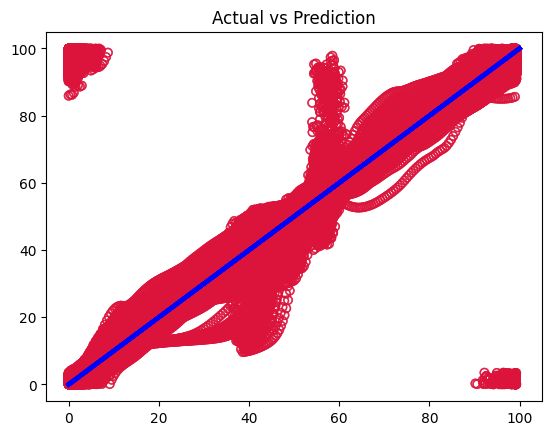

In [38]:
file_names = ['JL_I_0_new_.xlsx', 'JL_I_2_new_.xlsx','JL_I_3_new_.xlsx','JL_I_5_new_.xlsx','JL_I_4_new_.xlsx',
              'JS_I_1_new_.xlsx', 'JS_I_2_new_.xlsx','JS_I_3_new_.xlsx','JS_I_5_new_.xlsx','JS_I_4_new_.xlsx',
              'AK_I_0_new_.xlsx', 'AK_I_2_new_.xlsx','AK_I_3_new_.xlsx','AK_I_5_new_.xlsx','AK_I_4_new_.xlsx',
              'VN_I_0_new_.xlsx', 'VN_I_2_new_.xlsx','VN_I_3_new_.xlsx','VN_I_5_new_.xlsx','VN_I_4_new_.xlsx',
              'VP_I_0_new_.xlsx', 'VP_I_2_new_.xlsx','VP_I_3_new_.xlsx','VP_I_5_new_.xlsx','VP_I_4_new_.xlsx',
             'SOE_I_0_new_.xlsx', 'SOE_I_2_new_.xlsx','SOE_I_3_new_.xlsx','SOE_I_5_new_.xlsx', 'SOE_I_4_new_.xlsx', 'SD_I_3_new_.xlsx', 'SD_I_4_new_.xlsx','SD_I_5_new_.xlsx',
             'SD_I_1_new_.xlsx','SD_I_2_new_.xlsx','TH_I_0_new_.xlsx', 'TH_I_2_new_.xlsx', 'TH_I_3_new_.xlsx','TH_I_4_new_.xlsx', 'TH_I_5_new_.xlsx'
             ,'PK_I_0_new_.xlsx', 'PK_I_2_new_.xlsx', 'PK_I_3_new_.xlsx','PK_I_5_new_.xlsx',
              'SKS_0_I_new_.xlsx', 'SKS_2_I_new_.xlsx','SKS_3_I_new_.xlsx','SKS_4_I_new_.xlsx','SKS_5_I_new_.xlsx',
            'PH_I_0_new_.xlsx',  'PH_I_2_new_.xlsx',  'PH_I_3_new_.xlsx',  'PH_I_4_new_.xlsx',  'PH_I_5_new_.xlsx',
            'YC_I_0_new_.xlsx',  'YC_I_2_new_.xlsx',  'YC_I_3_new_.xlsx',  'YC_I_4_new_.xlsx',  'YC_I_5_new_.xlsx'
              ]
subject_dict = {'VN':[0.90,0.63],'AK':[0.80,0.57],'JS':[0.89,0.64],'JL':[0.79,0.63],'SKS':[0.83, 0.58],'VP':[0.93, 0.77],'SOE':[0.90, 0.83],
                'SD':[0.83, 0.70], 'TH':[0.66, 0.52], 'PK':[0.90, 0.88], 'PH':[0.95,0.80], 'YC':[0.82,0.79]}
subject_names = ['VP','AK', 'SD','PH', 'YC','JL','JS', 'PK', 'SOE', 'TH','SKS', 'VN']#,'VN','AK' 'SOE'
sub_comb_list=[]
test_sub_list=[]
acc_list=[]
rmse_list=[]
test_acc_list=[]
test_rmse_list=[]


#path="/home/vtp/Gait_Phase_Prediction/Subject_data/Final_files/"
#result_path = "/home/vtp/Gait_Phase_Prediction/Results/final/"

path = "/home/hikikomori/Gait_Phase_Prediction/Data/Final Data/"
result_path = "/home/hikikomori/Gait_Phase_Prediction/Results/final/"

result_pkl_file=result_path+'results_ver_cnn_both_.hipkl'
pkl_file=path+"all_sub_cnn_both_hip.pkl"
# pkl_file=path+"good_sub_data.pkl"

for sub in subject_names:

  test_sub_list.append(sub)
  tmp=subject_names.copy()
  tmp.remove(sub)
  sub_comb_list.append(tmp)

df_dict={}

if os.path.exists(pkl_file):
    # File is already in pickle format, read to dict
    with open(pkl_file, 'rb') as file:
        df_dict = pickle.load(file)
    
else:
    # File is not in pickle format/ does not exist, convert and save it as a pickle file

    for file_name in file_names:
        subject = file_name.split('_')[0]
        if subject not in subject_names:
            continue
        leg_len = subject_dict[subject][0]
        weight = subject_dict[subject][1]
        print("Reading file :", file_name)
        tmp=pd.read_excel(path+ file_name, sheet_name='Sheet1')

        #### Add r_ph_hip_l and r or l_ph_hip_l and l
        #encode_phase(tmp, 'r_ph_hip')
        #encode_phase(tmp, 'l_ph_hip')
    
        perc_column = tmp['perc']
        st_sw_col_l = tmp['st_sw_phase_l']
        st_sw_col_r= tmp['st_sw_phase_r']
        lhip_col = tmp['lhip_ang']
        rhip_col = tmp['rhip_ang']
        lhip_df=tmp['l_ph_hip']
        rhip_df=tmp['r_ph_hip']
        #r_hip_ph_x = tmp['r_ph_hip_x']
        #r_hip_ph_y = tmp['r_ph_hip_y']
        #l_hip_ph_x = tmp['l_ph_hip_x']
        #l_hip_ph_y = tmp['l_ph_hip_y']

        
        st_l_l_col = tmp[['st_l_l']]
        st_l_r_col = tmp[['st_l_r']]

        tmp = tmp.drop(columns=['perc', 'st_sw_phase_l', 'st_sw_phase_r', 'lhip_ang', 'rhip_ang','l_ph_hip','r_ph_hip', 'st_l_l', 'st_l_r'])#, 'r_ph_hip_x', 'r_ph_hip_y'])

        scaler = MinMaxScaler()
        tmp['l_ph_hip'] = lhip_df
        tmp['r_ph_hip'] = rhip_df
        tmp['st_sw_phase_l'] = st_sw_col_l
        tmp['st_sw_phase_r'] = st_sw_col_l
        #tmp['r_ph_hip_x'] = r_hip_ph_x
        #tmp['r_ph_hip_y'] = r_hip_ph_y
        #tmp['l_ph_hip_x'] = l_hip_ph_x
        #tmp['l_ph_hip_y'] = l_hip_ph_y
        tmp['st_l_l'] = scaler.fit_transform( st_l_l_col)
        tmp['st_l_r'] = scaler.fit_transform( st_l_r_col)

        column_names = tmp.columns


        tmp['l_ph_hip']=tmp['l_ph_hip']/300
        tmp['r_ph_hip']=tmp['r_ph_hip']/300
        #tmp['r_ph_hip_x'] = tmp['r_ph_hip_x'] / 300
        #tmp['r_ph_hip_y'] = tmp['r_ph_hip_y'] / 300
        # tmp['l_ph_fo']=tmp['l_ph_fo']/300
        # tmp['r_ph_fo']=tmp['r_ph_fo']/300
        tmp['lcop']= tmp['lcop']*1000
        tmp['rcop']=tmp['rcop']*1000
        tmp['st_sw_phase_l']=tmp['st_sw_phase_l']/200
        tmp['st_sw_phase_r']=tmp['st_sw_phase_r']/200

        normalized_df =tmp

        normalized_df['leg_len']=leg_len
        normalized_df['weight']=weight
        normalized_df['perc']= perc_column

        df_dict[subject] = normalized_df
    with open(pkl_file,'wb') as pickle_file:
        pickle.dump(df_dict, pickle_file)

#sub_cnt_file='sub_cnt.pkl'

with open(result_path+"all_results_cnn_both_hip.txt","w") as file:  
    for sub_iter, sub_comb in enumerate(sub_comb_list):
    #for a_ in range(len(subject_names)):
        #sub_file=open(sub_cnt_file,'rb')
        #cnt=pickle.load(sub_file)
        #sub_file.close()
        #if cnt==len(subject_names):
        #    print("Done with all subjects !!")
        #    break
        #sub_comb=sub_comb_list[cnt]
        #sub_iter=cnt
        print("Subject combination :",sub_comb)
        sub_tag=test_sub_list[sub_iter]
        # all_data=get_data_frames_from_files(path, file_names, subject_dict, sub_comb)
        file_list=[]
        for sub in sub_comb:
          tmp_df=df_dict[sub]
          file_list.append(tmp_df)
        random.shuffle(file_list)
        
        all_data = pd.concat(file_list, axis=0, ignore_index=True)
        print("All Data Info: ")
        all_data.info()
        train_x, train_y, validation_x, validation_y = get_train_data_from_df(all_data, 0.25)
        print("Nan in train x at indices:",np.argwhere(np.isnan(train_x)))
        print("Nan in train y at indices:",np.argwhere(np.isnan(train_y)))

        print(train_x.shape)
        print(validation_x.shape)
        print("SSS")
        seq_len = train_x.shape[1]
        n_features = train_x.shape[2]
     
        mlp_model=[]
        print("OKAY till here 1")

        look_back = 10

        mlp_model = train_mlp_model(train_x, train_y, look_back)
        file.write("Training Result :")
        file.write("\n")
        acc, rmse=test_model_get_results(mlp_model, validation_x, validation_y, False, sub_tag, file)
        acc_list.append(acc)
        rmse_list.append(rmse)
        print("testing on :", test_sub_list[sub_iter])
        file.write("Testing  Result :")
        file.write(test_sub_list[sub_iter])
        file.write("\n")
        # all_data=get_data_frames_from_files(path, file_names, subject_dict, [test_sub_list[sub_iter]])
        all_data = df_dict[test_sub_list[sub_iter]]
        test_x, test_y, validation_x, validation_y = get_train_data_from_df(all_data, 0.25)
        acc, rmse=test_model_get_results(mlp_model, test_x, test_y, True, sub_tag, file)
        # tf.keras.backend.clear_session()

        test_acc_list.append(acc)
        test_rmse_list.append(rmse)
        # break
        # file.write(acc)
        file.write("\n")
        #cnt=cnt+1
        #sub_file=open(sub_cnt_file,'wb')
        #pickle.dump(cnt, sub_file)
        #sub_file.close()
        # if sub_iter>=5:
        # break
    file.close()


In [39]:
personInfo = pickle.load(open(result_pkl_file, "rb"))
print(personInfo)

{'VP': {'rmse': 3.177005671444675, 'prec_list': [27.77927916861165, 51.4998894430386, 70.62133012308675, 83.0282780139056, 90.07689850870943]}, 'AK': {'rmse': 2.4921120307853797, 'prec_list': [29.43620317341095, 56.44070979250775, 76.76509247957938, 89.19819735236128, 95.30091071260914]}, 'SD': {'rmse': 2.0592519750834866, 'prec_list': [35.5119396260419, 66.14665465194864, 85.43027708943455, 93.73732822707817, 96.23225951790944]}, 'PH': {'rmse': 1.931391060280362, 'prec_list': [47.747339823409554, 76.30971247453023, 89.41589314014037, 94.0729001584786, 96.35499207606973]}, 'YC': {'rmse': 3.7948883749234184, 'prec_list': [29.999457612409827, 56.98324022346369, 75.94239843792374, 86.07962249823724, 90.6166946900255]}, 'JL': {'rmse': 2.1532363813180933, 'prec_list': [34.42613196882252, 63.37537930624145, 83.12607841970608, 93.45510799071815, 97.20057119057536]}, 'JS': {'rmse': 2.549310584144812, 'prec_list': [30.466841581471094, 57.330588980367324, 77.59205645526102, 88.92608341626708, 94

In [40]:
result_pkl_file = result_path + "results_ver_cnn_both_hip.pkl"

personInfo = pickle.load(open(result_pkl_file, "rb"))
print(personInfo)

FileNotFoundError: [Errno 2] No such file or directory: '/home/hikikomori/Gait_Phase_Prediction/Results/final/results_ver_cnn_both_hip.pkl'